<center><h1>1-e: Transformer</h1></center>
<center><h2><a href="https://rdfia.github.io/">Course link</a></h2></center>


In this notebook, we will implement the first Visual Transformer, [ViT](https://arxiv.org/abs/2010.11929). We'll implement a naive version of it, much smaller than the ones described in the paper, and we also won't use complex data augmentation and regularizations. But note that this is important to make transformers work in practice on large-scale dataset.

To get a gist of what is required to make a transformer work in practice, have a look at the [DeiT and CaiT codebase](https://github.com/facebookresearch/deit).

This notebook is a simplified version of the excellent [Timm library](https://github.com/rwightman/pytorch-image-models).

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pickle
import math

import numpy as np
import torch
from torch import nn, Tensor
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import torchvision.utils as vutils
import torchvision
from PIL import Image

Let's load the MNIST dataset:

In [3]:
transform = transforms.Compose([
  transforms.ToTensor()
])

train_dataset = torchvision.datasets.MNIST('.', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST('.', train=False, download=True, transform=transform)


train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128)

100%|██████████| 9912422/9912422 [00:00<00:00, 131841150.37it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 103094207.51it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32497809.78it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 23035705.89it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



... and visualize!

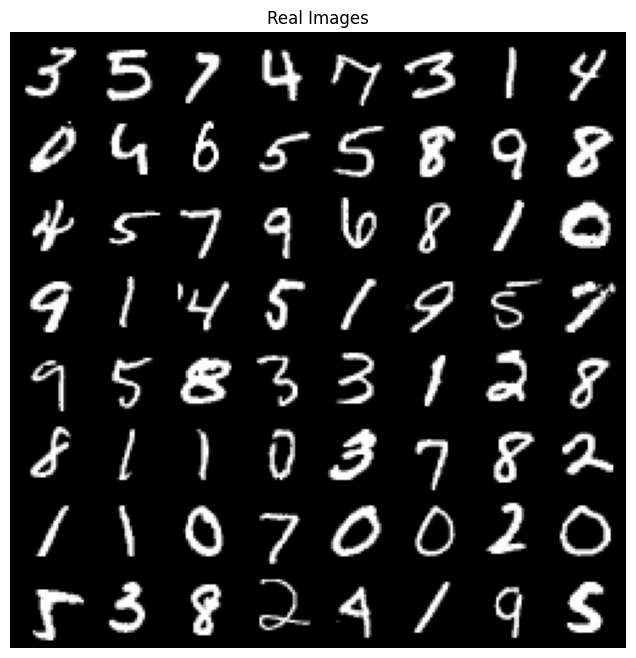

In [4]:
real_batch = next(iter(train_loader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Real Images")
plt.imshow(vutils.make_grid(real_batch[0][:64], normalize=True).permute(1,2,0))
plt.show()

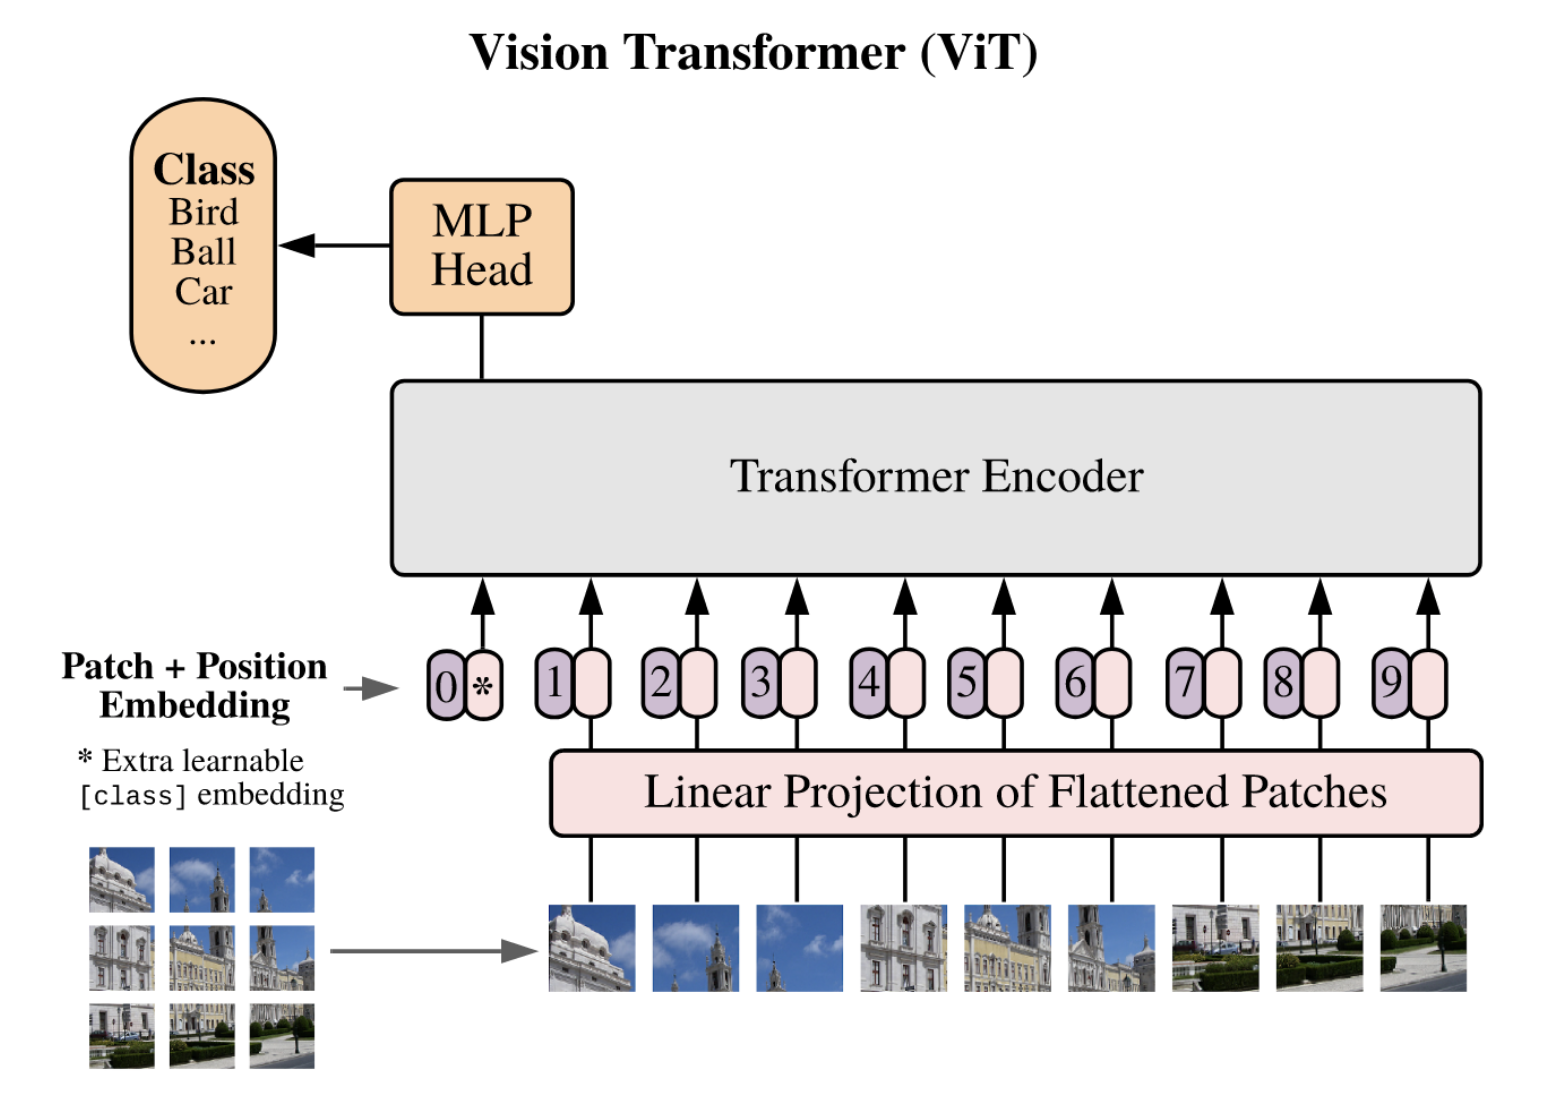

# I. Implementing ViT

**Q1**:
First, we need to code the patch embedding. In NLP, it could be using a word2vec embeddings, but we need something different in Computer Vision.

You are going to use a 2d convolution (called "Linear Projection" on the image above) to process each patch independently without overlap. Think a bit how you could do that.

Then, you need to manipulate the dimensions of the resulting tensor to get a final tensor of shape `(batch_size, nb_tokens, embedding_dim)`. *Hint: You will need a `view/reshape` and `transpose/permute` operators*.

As usual, remember to check the output shape of your layer by trying with a random tensor!

### Patch Embedding

In [5]:
#my implementation

class PatchEmbed(nn.Module):
  def __init__(self, in_chan=1, patch_size=7, embed_dim=128):
    super().__init__()
    H = 28 #MNIST

    self.embed_dim = embed_dim
    self.num_patches = H // patch_size #get the number of patches, the stride will be the same as the size of the patch to avoid overlap

    self.projection = nn.Conv2d(in_channels = in_chan, out_channels = embed_dim, kernel_size = patch_size, stride = patch_size)

  def forward(self, x):

    x = self.projection(x)
    B, C, H, W = x.shape

    nb_tokens = self.num_patches **2 # number of tokens is number of overall patches
    x = x.reshape(B, C, nb_tokens , -1) #keep batch size and channel size
    x = x.permute(0, 2, 1, 3) # --> B, nb_tokens, C, -1

    return x.view(B, -1, C) #channels from convolution have become features


Shape of input batch:  (128, 1, 28, 28)
Shape of encoded batch:  torch.Size([128, 16, 128])


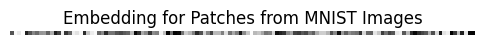

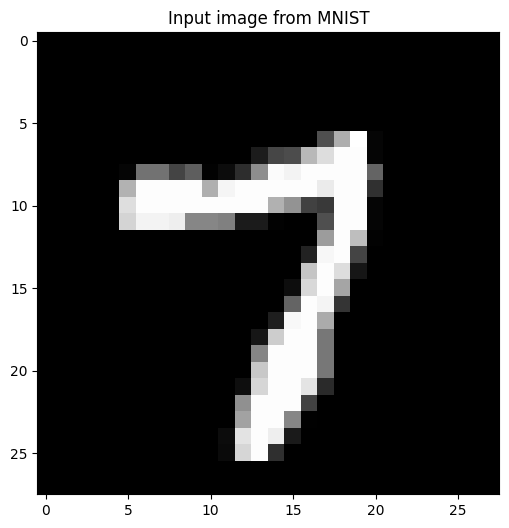

In [23]:
# test PatchEmbed
patch_embed = PatchEmbed(in_chan=1, patch_size=7, embed_dim=128)

# get one batch
test_batch = next(iter(train_loader))

print('Shape of input batch: ', np.array(test_batch[0]).shape)
patches = patch_embed(test_batch[0])
print('Shape of encoded batch: ', patches.shape)

plt.figure(figsize=(6, 2))
plt.axis("off")
plt.title("Embedding for Patches from MNIST Images")
plt.imshow(vutils.make_grid(patches[0][:1], normalize=True).permute(1, 2, 0).cpu().detach().numpy())
plt.show()

plt.figure(figsize=(6, 6))
plt.title("Input image from MNIST")
plt.imshow(vutils.make_grid(test_batch[0][:1], normalize=True).permute(1, 2, 0).cpu().detach().numpy())
plt.show()

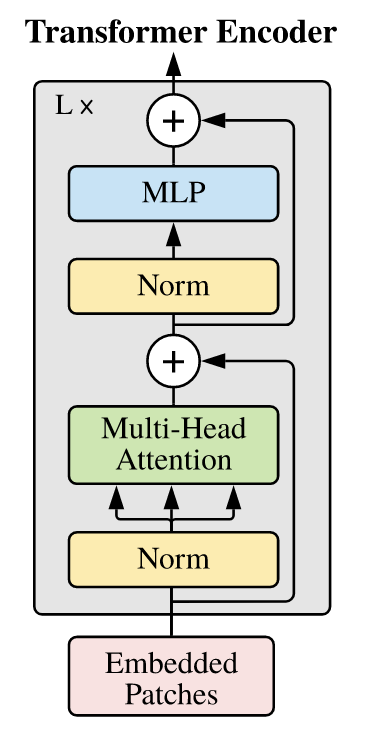

**Q2**: Now we need to build a transformer block. Let's first build the easiest part, the MLP! By now, you should be confident how to code one.

Code a MLP with one hidden layer. Note that the input and output dimensions will be the same. Instead of ReLU, use the activation GELU, which is a slight alternative often used for transformers.

In [7]:
class MLP(nn.Module):
  def __init__(self, in_features, hid_features):
    super().__init__()

    self.in_features = in_features
    self.hid_features = hid_features
    #modules = []

    self.lin1 = nn.Linear(in_features, hid_features)
    self.gelu1 = nn.GELU()

    self.lin2 = nn.Linear(hid_features, in_features)
    self.gelu2 = nn.GELU()

  def forward(self, x):
    x = self.gelu2((self.lin2(self.gelu1(self.lin1(x)))))

    return x

MLP(128, 512)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

### Self-Attention Mechanism

**Q3**: Now we are going to build the famous **Self-Attention**. At first, we are going to only consider the simple case of one head. Write the equations and complete the following code.

And don't forget a final linear projection at the end!

$$ Q = X \, W_Q  \in \mathbb{R}^{T \times d_K}  \text{ (Query)} \\
K = X \,  W_K \in \mathbb{R}^{T \times d_K} \text{ (Key)} \\
V = X \,  W_V \in \mathbb{R}^{T \times d_V} \text{ (Value)} \\
T: \text{sequence length} \\
d_K, d_V: \text{hidden (embedding) dimension of queries/keys/ values, here: } d_K = d_V
$$

In [8]:
class SelfAttention(nn.Module):
  """Implements dot-product self-attention/computes self-attention scores

    Args:
        embed_dim (int): The input feature dimension for Q, K, and V.

    Attributes:
        embed_dim (int): The input feature dimension for Q, K, and V.
        W_q (nn.Linear): Linear projection for the query vector.
        W_k (nn.Linear): Linear projection for the key vector.
        W_v (nn.Linear): Linear projection for the value vector.

    """
  def __init__(self, embed_dim):
    super().__init__()

    # TODO
    self.embed_dim = embed_dim
    self.W_q = nn.Linear(embed_dim, embed_dim)     # linear projections for Q, K, and V
    self.W_k = nn.Linear(embed_dim, embed_dim)
    self.W_v = nn.Linear(embed_dim, embed_dim)

  def forward(self, x):
    """Forward pass of the self-attention module.

        Args:
            x (torch.Tensor): Input tensor of shape (B, N, C), where B is batch size, N is sequence length,
                             and C is the input feature dimension.
        Returns:
            torch.Tensor: Output tensor after applying self-attention of the same shape as input x.
        """
    B, N, C = x.shape

    # TODO: compute the Q, K, V
    q = self.W_q(x) # computes query vector
    k = self.W_k(x) # computes key vector
    v = self.W_v(x) # computes value vector

    # TODO: compute the attention matrix using Q and K
    attention = torch.softmax(torch.matmul(q, k.transpose(1, 2)) / (C ** 0.5), dim=-1) # ATTENTION MATRIX + normalization with sqrt(d)

    # TODO: compute the final version using the attention,
    # V, and the final projection
    x = torch.matmul(attention, v)

    return x #, attention

SelfAttention(128)(torch.randn(32, 16, 128)).shape

torch.Size([32, 16, 128])

## Multi-Head Self-Attention

**Q4**: Now we need to build a Multi-Heads Self-Attention. Write the equations and complete the following code to build a Multi-Heads Self-Attention.

The total embedding size will be shared equally among all heads.

$$
\text{MultiHeadAttention}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h) W^0 \\
\text{head}_i = \text{self-attention}( Q W_i^Q, K W_i^K, V W_i^V )$$

**Vizualization of Multi-Head Attention Layer**
 <br>
<img src=https://www.researchgate.net/publication/363678304/figure/fig3/AS:11431281085295692@1663701178894/The-structure-of-the-transformer-block.ppm width="500">



In [9]:
class MultiHeadsSelfAttention(nn.Module):
    """Implements multi-head self-attention mechanism.

      This module implements the multi-head self-attention mechanism. The input
      tensor is divided into multiple heads, each with its own set of query, key,
      and value projections, and the attention mechanism is applied to each head.
      The outputs of all heads are concatenated and projected to produce
      the final output.

      Args:
          embed_dim (int): The input feature dimension for Q, K, and V.
          num_heads (int): The number of attention heads.

      Attributes:
          head_dim (int): The dimension of each attention head.
          scale (float): The scaling factor for attention scores.
          num_heads (int): The number of attention heads.
          W_q (nn.Linear): Linear projection for the query vector.
          W_k (nn.Linear): Linear projection for the key vector.
          W_v (nn.Linear): Linear projection for the value vector.
          projection (nn.Linear): Linear projection for the final output.

      """
    def __init__(self, embed_dim, num_heads): #input_dim, embed_dim, num_heads
        super().__init__()

        # Calculate the dimension of each attention head
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5
        self.num_heads = num_heads

        # Linear projections for Q, K, and V for each head
        self.W_q = nn.Linear(embed_dim, embed_dim)
        self.W_k = nn.Linear(embed_dim, embed_dim)
        self.W_v = nn.Linear(embed_dim, embed_dim)

        # Linear projection for the final output
        self.projection = nn.Linear(embed_dim, embed_dim) #final projection with weight matrix W^0


    def forward(self, x):
        B, N, C = x.shape # batch size, sequence length, channels

        #d_k = q.size()[-1]
        #values = SelfAttention(embed_dim=d_k)(q,k,v) --> rewrite to use self-attention module

        # Linear projections for Q, K, and V for each head
        q = self.W_q(x).view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        k = self.W_k(x).view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)
        v = self.W_v(x).view(B, N, self.num_heads, self.head_dim).permute(0, 2, 1, 3)

        # Compute attention scores using Q and K
        attention = torch.matmul(q, k.permute(0, 1, 3, 2)) * self.scale
        attention = torch.softmax(attention, dim=-1)

        # Apply attention to V
        x = torch.matmul(attention, v)

        # Reshape and concatenate attention outputs
        x = x.permute(0, 2, 1, 3).contiguous().view(B, N, C)
        # contiguous makes a copy of the tensor such that the order of its elements in memory
        # is the same as if it had been created from scratch with the same data. Some pytorch tensor operations
        # leave the memory arrangement unchanged

        # Apply the final projection
        x = self.projection(x)

        return x

# Test the MultiHeadsSelfAttention module with example data
x = torch.randn(32, 16, 6)  # Example input
output_shape = MultiHeadsSelfAttention(6, 2)(x).shape
print(output_shape)

torch.Size([32, 16, 6])


## Transformer Block

**Q5**: Now, we need to build a Transformer **Block** as described in the image below.
Write the equations and complete the following code. (Don't forget other components such as LayerNorm)

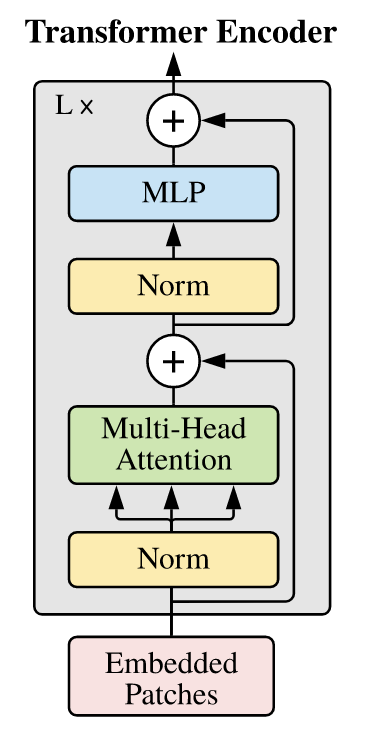

In [10]:
class Block(nn.Module):
    def __init__(self, embed_dim, num_heads=4, mlp_ratio=4):
        super().__init__()

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_ratio = mlp_ratio

        # layer norm
        self.norm1 = nn.LayerNorm(embed_dim)

        # multi-head self-attention
        self.self_attention = MultiHeadsSelfAttention(embed_dim, num_heads)

        # layer norm
        self.norm2 = nn.LayerNorm(embed_dim)

        # MLP embed_dim --> 4*embed_dim --> embed_dim
        self.feed_forward = MLP(embed_dim, mlp_ratio*embed_dim)

    def forward(self, x):
        # input layer norm
        x1 = self.norm1(x)

        # self-attention
        attn_out = self.self_attention(x1)

        # add layer
        x2 = attn_out + x

        # second layer normalization
        x3 = self.norm2(x2)

        # MLP layer
        x4 = self.feed_forward(x3)

        # add layer
        x_final = x2 + x4

        return x_final

# Example usage:
output_shape = Block(128)(torch.randn(32, 16, 128)).shape
print(output_shape)

torch.Size([32, 16, 128])


**Q6**: Now you need to build a ViT model based on what you coded in the previous questions. There are additional components that should be coded such as the Class token, Positional embedding and the classification head.

**a)** Explain what is a class token and why we use it? \\
&#10148; Initialized randomly, will be trained during traning by backprob, weight vector, it is re-embedded again and again through the transformer network. \\
&#10148; Comes in at the end for the classification. Information accumulates in the class token. Idea comes from Bert (NLP model) \\
&#10148; In this setup, the MLP works only on the learned class tokens. \\
**b)** Explain what is the the positional embedding and why it is important? \\
&#10148;  Multi-head attention layer is permutation equivariant (does not change with changed word/patch order). Therefore, we have to pass additional clues to the model to respect the word order within a sentence. \\
We use it so as not to loose the information about the spatial position of the patches \\
&#10148; include graph of sinus/cosinus for positional embedding \\
**c)** Test different hyperparameters and explain how they affect the performance. In particular embed_dim, patch_size, and nb_blocks.


### Rewrite positional encoding formula

$$
\text{PE}(k, i) = \begin{cases} \sin{\left( \frac{\text{position}}{10000^{\frac{i}{d}}} \right)} \text{ if } i \text{ even} \\
\cos{\left( \frac{\text{position}}{10000^{\frac{(i-1)}{d}}} \right)} \text{ else}  \end{cases}
\\
\Leftrightarrow  \\
\text{PE}(k, 2i) = \sin{\left( \frac{\text{position}}{10000^{\frac{2i}{d}}} \right)} \\
\text{PE}(k, 2i+1) = \cos{\left( \frac{\text{position}}{10000^{\frac{2i}{d}}} \right)}
$$

<img src="https://miro.medium.com/v2/resize:fit:1400/format:webp/1*SMXg-0Yd-x-6g818nUfsUw.png" width=700 />

In [11]:
"""def get_positional_embedding(sequence_length, d):
  result = torch.ones(1, sequence_length, d)
  for i in range(sequence_length):
    for j in range(d):
      result[0][i][j] = np.sin(i / 10000 **(j/d)) if j% 2 ==0 else np.cos(i / (10000 ** ((j-1)/d)))

# test get_positional_embedding

get_positional_embedding(2, 3)"""

'def get_positional_embedding(sequence_length, d):\n  result = torch.ones(1, sequence_length, d)\n  for i in range(sequence_length):\n    for j in range(d):\n      result[0][i][j] = np.sin(i / 10000 **(j/d)) if j% 2 ==0 else np.cos(i / (10000 ** ((j-1)/d)))\n\n# test get_positional_embedding\n\nget_positional_embedding(2, 3)'

In [12]:
class PositionalEncoding(nn.Module):
  """
  Taken from pytorch documentation: https://pytorch.org/tutorials/beginner/transformer_tutorial.html
  """
  def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()

        position = torch.arange(max_len).unsqueeze(1)

        #use torch.exp instead of 10000**2 --> convert with log
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))

        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe) # non-learnable parameters that are saved in state_dict
        #register_parameter

  def forward(self, x: Tensor) -> Tensor:
        x = x + self.pe[:x.size(0)]
        return x

## Complete ViT model (incl. training)

In [13]:
class ViT(nn.Module):
  def __init__(self, embed_dim, nb_blocks, patch_size, nb_classes=10):
    super().__init__()

    num_patches = (28 // patch_size) ** 2

    self.class_token = nn.Parameter(torch.zeros(1, 1, embed_dim)) #None
    self.pos_embed = PositionalEncoding(embed_dim)
    self.patch_embed = PatchEmbed(patch_size=patch_size, embed_dim=embed_dim)

    blocks = []
    for _ in range(nb_blocks):
      blocks.append(
          Block(embed_dim)
      )
    self.blocks = nn.Sequential(*blocks)

    self.norm = nn.LayerNorm(embed_dim)
    self.head = nn.Linear(embed_dim, nb_classes)#None


  def forward(self, x):
    ## image to patches
    x = self.patch_embed(x)

    ## concatenating class token
    B, N, _ = x.shape
    class_tokens = self.class_token.expand(B, -1, -1)
    x = torch.cat([class_tokens, x], dim=1)

    ## adding positional embedding
    x = x + self.pos_embed(x)

    ## forward in the transformer
    x = self.blocks(x)

    ## Normalize the output
    x = x = self.norm(x)

    output = self.head(x[:, 0]) ## classification output

    return output


ViT(128, 3, 7)(torch.randn(32, 1, 28, 28)).shape

torch.Size([32, 10])

A quick function to evaluate our model:

In [14]:
@torch.no_grad()
def eval_model(model, loader):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

And run! Feel free to try other hyperparameters.

--- Epoch 0 ---
Train loss: 1.236088256719016
--- Epoch 1 ---
Train loss: 0.6313036036516811
--- Epoch 2 ---
Train loss: 0.4597327410857052
--- Epoch 3 ---
Train loss: 0.37126803185258594
--- Epoch 4 ---
Train loss: 0.32055830876074876
--- Epoch 5 ---
Train loss: 0.2796936371464973
--- Epoch 6 ---
Train loss: 0.25415230702870945
--- Epoch 7 ---
Train loss: 0.23546013371077681
--- Epoch 8 ---
Train loss: 0.21653906802442283
--- Epoch 9 ---
Train loss: 0.20543568332725243
Test accuracy: 93.12%


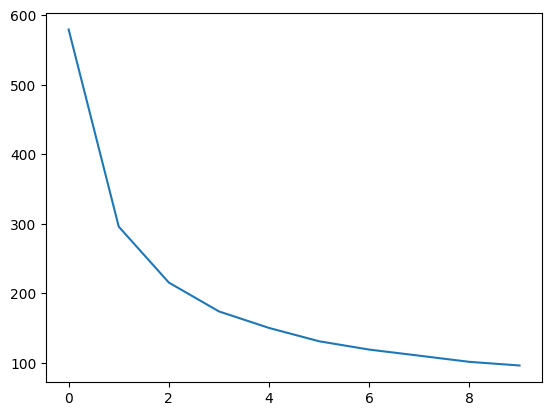

In [15]:
epochs = 10

embed_dim = 32
patch_size = 7
nb_blocks = 2

model = ViT(embed_dim, nb_blocks, patch_size).cuda()

opt = torch.optim.Adam(model.parameters())

train_loss_stat = []
eval_loss_stat = []

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  train_loss_stat.append(train_loss)
  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader)
print(f"Test accuracy: {acc}%")
plt.plot(train_loss_stat)


**Q7:** What is the complexity of the transformer in terms of number of tokens? and how you can improve it (you check latest papers on this topic)

**Q8:** Try to use bigger transformer, for example the ViT-S from the timm library. Test with and without intialization from imagenet.

In [ ]:
!pip install timm

# II. Switching to timm library

## Evaluating on MNIST

a) Load the model using the timm library without pretrained wewights. Try to apply it directly on a tensor with the same MNIST images resolution. What it is the problem and why we have it? Explain if we have also such problem with CNNs. As ViT takes RGB images, the input tensor should have 3 channels.

$\to$ Input shape is fixed for CNNs and ViTs by choice of architecture. We can go around by rezising (shrinking or interpolating) but we are not ideally using either the image details or the efficiency of the CNN. (same for channels)


In [17]:
import timm
timm.list_models()[:5] # get first 5 models of available timm models

['bat_resnext26ts',
 'beit_base_patch16_224',
 'beit_base_patch16_384',
 'beit_large_patch16_224',
 'beit_large_patch16_384']

In [18]:
model = timm.create_model('vit_small_patch8_224', pretrained = False) # vit model with 8x8 image patches on 224x224 images
model

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 384, kernel_size=(8, 8), stride=(8, 8))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity()
  

In [19]:
data_config = timm.data.resolve_model_data_config(model)
transforms = timm.data.create_transform(**data_config, is_training=False)
data_config

{'input_size': (3, 224, 224),
 'interpolation': 'bicubic',
 'mean': (0.485, 0.456, 0.406),
 'std': (0.229, 0.224, 0.225),
 'crop_pct': 0.9,
 'crop_mode': 'center'}

In [20]:
x = torch.randn(32, 1, 28, 28)
x =  torch.cat([x,x,x], dim = 1) # adapt number of channels to fit in ViT, all channels identical
print('input shape = ', x.shape)
x = torchvision.transforms.Resize(224)(x)

model(x).shape

input shape =  torch.Size([32, 3, 28, 28])


/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


torch.Size([32, 384])

b) There is a trick in timm that allows to use pretrained models with different image resolution and number of classes. Try to reload the model to be able to use on MNIST images:

In [24]:
timm.list_models('*vit_s*')

['convit_small',
 'crossvit_small_240',
 'davit_small',
 'fastvit_s12',
 'fastvit_sa12',
 'fastvit_sa24',
 'fastvit_sa36',
 'flexivit_small',
 'gcvit_small',
 'maxvit_small_tf_224',
 'maxvit_small_tf_384',
 'maxvit_small_tf_512',
 'mobilevit_s',
 'vit_small_patch8_224',
 'vit_small_patch14_dinov2',
 'vit_small_patch16_18x2_224',
 'vit_small_patch16_36x1_224',
 'vit_small_patch16_224',
 'vit_small_patch16_384',
 'vit_small_patch32_224',
 'vit_small_patch32_384',
 'vit_small_r26_s32_224',
 'vit_small_r26_s32_384',
 'vit_small_resnet26d_224',
 'vit_small_resnet50d_s16_224',
 'vit_so400m_patch14_siglip_224',
 'vit_so400m_patch14_siglip_384',
 'vit_srelpos_medium_patch16_224',
 'vit_srelpos_small_patch16_224']

In [25]:
# create new model with specs for MNIST dataset (3,28,28) sized images
model = timm.create_model('vit_small_patch16_224', pretrained = True, in_chans = 3, img_size=28)

model(torch.randn(32, 3, 28, 28)).shape

model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

torch.Size([32, 1000])

## Redo the training with the pretrained ViT-S on MNIST





In [26]:
@torch.no_grad()
def eval_model(model, loader, num_channels=1):
  model.eval()
  acc = 0.
  c = 0

  for x, y in loader:
    x, y = x.cuda(), y.cuda()
    B, C, W, H = x.shape

    #if C != num_channels:
      #x = torchvision.transforms.Grayscale(x, num_output_channels = num_channels)
      #x = torch.cat([x,x,x], dim = 1)  # adapt number of channels to fit in ViT

    yhat = model(x)

    acc += torch.sum(yhat.argmax(dim=1) == y).cpu().item()
    c += len(x)

  model.train()
  return round(100 * acc / c, 2)

In [27]:
import timm
from tqdm import tqdm

model = timm.create_model('vit_small_patch16_224', pretrained = True, in_chans = 1, img_size=28)

model.cuda()
model.train()

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in tqdm(range(epochs)):
  train_loss = 0.

  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()
    #print(x.shape)

    opt.zero_grad()
    #x = None # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"\n--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")

acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

 10%|█         | 1/10 [00:21<03:09, 21.03s/it]


--- Epoch 0 ---
Train loss: 0.613993876969128


 20%|██        | 2/10 [00:41<02:46, 20.77s/it]


--- Epoch 1 ---
Train loss: 0.31921581177314967


 30%|███       | 3/10 [01:02<02:25, 20.75s/it]


--- Epoch 2 ---
Train loss: 0.27096813856792856


 40%|████      | 4/10 [01:22<02:03, 20.54s/it]


--- Epoch 3 ---
Train loss: 0.24566822406897412


 50%|█████     | 5/10 [01:43<01:42, 20.58s/it]


--- Epoch 4 ---
Train loss: 0.22554646858941518


 60%|██████    | 6/10 [02:03<01:22, 20.61s/it]


--- Epoch 5 ---
Train loss: 0.20773834693851248


 70%|███████   | 7/10 [02:23<01:01, 20.44s/it]


--- Epoch 6 ---
Train loss: 0.19678278696308257


 80%|████████  | 8/10 [02:44<00:41, 20.53s/it]


--- Epoch 7 ---
Train loss: 0.18028446661034372


 90%|█████████ | 9/10 [03:05<00:20, 20.52s/it]


--- Epoch 8 ---
Train loss: 0.1648866811286666


100%|██████████| 10/10 [03:25<00:00, 20.54s/it]


--- Epoch 9 ---
Train loss: 0.15878221491125347


Test accuracy: 91.13


## Redo the training but with the ViT-S pretrained on ImageNet

In [ ]:
model = timm.create_model('vit_small_patch16_224', pretrained = True, in_chans = 1, img_size=28)
train_loader =

In [ ]:
import timm

epochs = 10

opt = torch.optim.Adam(model.parameters())

for epoch in range(epochs):
  train_loss = 0.
  for x, y in train_loader:
    x, y = x.cuda(), y.cuda()

    opt.zero_grad()
    x = None # adapt number of channels to fit in ViT
    yhat = model(x)
    loss = F.cross_entropy(yhat, y)
    loss.backward()

    opt.step()

    train_loss += loss.item()

  print(f"--- Epoch {epoch} ---")
  print(f"Train loss: {train_loss / len(train_loader)}")
acc = eval_model(model, test_loader, num_channels=3)
print(f"Test accuracy: {acc}")

d) Comment the final results and provide some ideas on how to make transformer work on small datasets. You can take inspiration from some recent work. \\
&#10148; Transformers as many NNs are overparametrized for small datasets and we have to rely on regularization techniques (e.g. early stopping, dropout,...) or increase the number of training samples (e.g. training augmentations, pre-training on a different dataset and finetuning afterwards (transfer learning),...)